# 1D Bragg Grating

This example illustrates the use of the scattering matrix in a simple 1D case, namely an uniform Bragg grating. Although the simulation is quite simple, it constitutes a good starting point, both theoretically and computationally. Indeed, most to the physics and of the computational methods showed here are the same found in more complex simulations. 

The grating in question is built by a periodic repetition of 2 transparent materials (dielectric constant 12.0 and 2.0, respectively). The duty cycle of the grating is 50% and everything is calculated in dimensionless units (or, equivalently, the period of the grating is set to 1).


## Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import A_FMM

 ## Transmission and reflection from a finite multilayer <a id='finitegrating'></a>

**Building the structure**

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


(Text(0.5, 0, 'z'),
 Text(0, 0.5, 'x'),
 <matplotlib.colorbar.Colorbar at 0x7f44444a6380>)

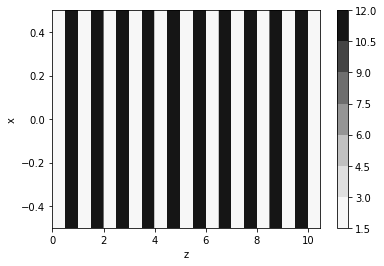

In [2]:
import cmath


lay1 = A_FMM.Layer_uniform(0,0,2.0)
lay2 = A_FMM.Layer_uniform(0,0,12.0)

mat = 10*[lay1, lay2] + [lay1]
d   = 10*[0.5, 0.5]   + [0.5]

st = A_FMM.Stack(mat, d)
eps = st.calculate_epsilon(x=[-0.5, 0.5], z = np.linspace(0.0, st.total_length, 1001))
plt.contourf(np.squeeze(eps['z']), np.squeeze(eps['x']), np.squeeze(eps['eps']), cmap='Greys')
plt.xlabel('z'), plt.ylabel('x'), plt.colorbar()


**Transmission and reflection at normal incidence**

In [3]:
oml = np.linspace(0.0005, 0.6,1200)
DATA = []
for om in oml:
    st.solve(om)
    T,R = st.get_T(0,0, ordered = False), st.get_R(0,0, ordered = False)
    DATA.append((T,R))
    
DATA = pd.DataFrame(DATA, index = oml, columns = ['T', 'R'])

(Text(0.5, 0, 'k_0'),
 Text(0, 0.5, 'T'),
 <matplotlib.legend.Legend at 0x7f4442251450>)

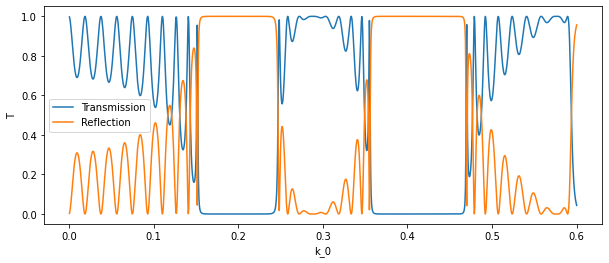

In [4]:
plt.figure(figsize = (10,4))
plt.plot(DATA['T'], label = 'Transmission')
plt.plot(DATA['R'], label = 'Reflection')
plt.xlabel('k_0'), plt.ylabel('T'), plt.legend()

**Transmission and reflection at an angle**

In [5]:
oml = np.linspace(0.002, 0.6,300)
angles = np.linspace(0,89,90)
DATA = []
for om in oml:
    for angle in angles:
        st.solve(om, kx = om*np.sqrt(2.0)*np.sin(np.pi*angle/180.0))
        RE, TE, RM, TM = st.get_R(1,1,ordered=False), st.get_T(1,1,ordered=False), st.get_R(0,0,ordered=False), st.get_T(0,0,ordered=False) 
        DATA.append((om, angle, RE, TE, RM, TM))
        
DATA = pd.DataFrame(DATA, columns = ['om', 'angle', 'R_TE', 'T_TE', 'R_TM', 'T_TM'])  

(Text(0.5, 0, 'angle (deg)'),
 Text(0, 0.5, 'k_0'),
 <matplotlib.colorbar.Colorbar at 0x7f44422cb610>)

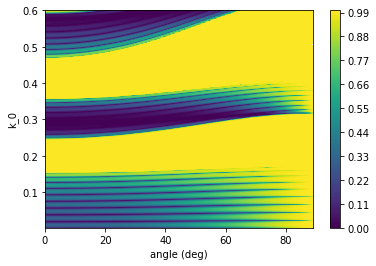

In [6]:
OM, ANG = np.meshgrid(oml, angles, indexing = 'ij')
plt.contourf(angles, oml, DATA.pivot('om', 'angle', 'R_TE'), levels = 101)
plt.xlabel('angle (deg)'), plt.ylabel('k_0'), plt.colorbar()

(Text(0.5, 0, 'angle (deg)'),
 Text(0, 0.5, 'k_0'),
 <matplotlib.colorbar.Colorbar at 0x7f4441a513c0>)

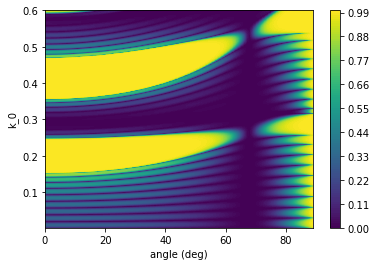

In [7]:
plt.contourf(angles, oml, DATA.pivot('om', 'angle', 'R_TM'), levels = 101)
plt.xlabel('angle (deg)'), plt.ylabel('k_0'), plt.colorbar()

### Band structure infinite Bragg Grating
A convenient way to make sense of reflection and transmission spectra of a Bragg grating is to look at the band structure. This also can be done with the Aperiodic Fourier Modal Method, since it is possible, given the scattering matrix of the unit cell, to get the Bloch modes by simply solving an eigenvalue problem.

First step is to build the stack object representing the unit cell. In the following the unit cell of the same grating analyzed in the [previos section](#finitegrating). It is worth noting that, due to the way the first and last layer are handled by the code, their thickness will not be included in the unit cell. Thus, first and last layer are irrelevant to the code, but they need to be the same in order for the code to work properly.

Thus, this is how the cell is built:

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


(Text(0.5, 0, 'z'),
 Text(0, 0.5, 'x'),
 <matplotlib.colorbar.Colorbar at 0x7f44422bcc40>)

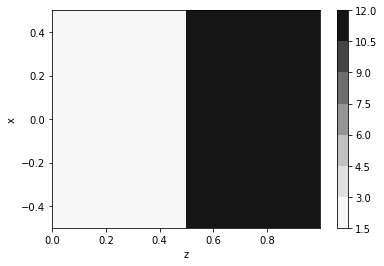

In [8]:
mat = [lay1, lay1, lay2, lay1]
d   = [0.0,0.5, 0.5,0.0]
st = A_FMM.Stack(mat, d)
eps = st.calculate_epsilon(x=[-0.5, 0.5], z = np.linspace(0.0, st.total_length, 1001))
plt.contourf(np.squeeze(eps['z']), np.squeeze(eps['x']), np.squeeze(eps['eps']), cmap='Greys')
plt.xlabel('z'), plt.ylabel('x'), plt.colorbar()

After that, getting the Bloch mode just requires to calculate the scattering matrix by calling `solve` and the solving for the Bloch vector by calling `bloch_modes`, which returns an array containing the found Bloch vectors. In general the Bloch vector is a complex quantity, where the real part represent the evolution of the phase and the imaginary part the evolution of the amplitude. The returned Bloch vectors are ordered by increasing imaginary part. 

In [9]:
DATA = []
for om in oml:
    st.solve(om)
    bm = st.bloch_modes()
    DATA.append([om, bm[0]])
    
DATA = pd.DataFrame(DATA, columns = ['om', 'bk'])

The obtained Bloch vector can then be plotted against the frequency:

(Text(0.5, 0, 'k_b'),
 Text(0, 0.5, 'k_0'),
 <matplotlib.legend.Legend at 0x7f4444342320>)

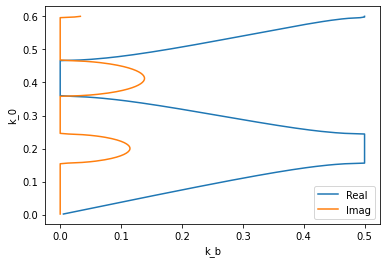

In [10]:
plt.plot(np.abs(np.real(DATA['bk'])), DATA['om'], label='Real')
plt.plot(np.imag(DATA['bk']), DATA['om'], label='Imag')
plt.xlabel('k_b'), plt.ylabel('k_0'), plt.legend()